# Comomentum Phase B (9ETF + FF3 Weekly, Notebook表示のみ)

このノートブックは `Comomentum` 論文のコア検証を、ローカルの 9ETF + FF因子でプロキシ再現する。

- 保存先への書き出し（CSV/PNG/Runlog）は行わない
- `t` で計算したシグナルを `t+1` に適用する時点整合を厳守
- 分析期間は FF週次因子が利用可能な `2011-01` から `2025-12` に固定


In [1]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display, Markdown

plt.style.use('ggplot')
pd.set_option('display.width', 180)
pd.set_option('display.max_columns', 50)

BASE = Path('/Users/kencharoff/workspace/projects/momentum/p02_comomentum')
DATA = BASE / 'data'

PRICE_CSV = DATA / 'prices.csv'
FF_WEEKLY_CSV = DATA / 'F-F_Research_Data_Factors_weekly.csv'
FF5_MONTHLY_CSV = DATA / 'F-F_Research_Data_5_Factors_2x3.csv'
MOM_MONTHLY_CSV = DATA / 'F-F_Momentum_Factor.csv'

TICKERS = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
COST_BPS = 10.0
COMOM_LOOKBACK_WEEKS = 52
N_LONG = 3
N_SHORT = 3
ANALYSIS_END = pd.Timestamp('2025-12-31')

print('data dir:', DATA)
print('tickers:', TICKERS)
print('analysis_end:', ANALYSIS_END.date())


data dir: /Users/kencharoff/workspace/projects/momentum/p02_comomentum/data
tickers: ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
analysis_end: 2025-12-31


## Data Loading Helpers

指定I/F:
1. `load_prices(csv_path: str, tickers: list[str]) -> pd.DataFrame`
2. `load_ff_weekly(ff_weekly_csv: str) -> pd.DataFrame`
3. `load_ff_monthly(ff5_csv: str, mom_csv: str) -> pd.DataFrame`


In [2]:
def _parse_ff_dates(df: pd.DataFrame, date_col: str) -> pd.Series:
    s = df[date_col].astype(str).str.strip()

    mask8 = s.str.fullmatch(r'\d{8}')
    if mask8.any():
        out = pd.to_datetime(s, format='%Y%m%d', errors='coerce')
        return out

    mask6 = s.str.fullmatch(r'\d{6}')
    if mask6.any():
        out = pd.to_datetime(s + '01', format='%Y%m%d', errors='coerce') + pd.offsets.MonthEnd(0)
        return out

    return pd.to_datetime(s, errors='coerce')


def _clean_ff_numeric(df: pd.DataFrame, cols: Iterable[str]) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        out[c] = pd.to_numeric(out[c], errors='coerce')
    out = out.replace([-99.99, -999], np.nan)
    out[list(cols)] = out[list(cols)] / 100.0
    return out


def load_prices(csv_path: str, tickers: list[str]) -> pd.DataFrame:
    """Load daily Adj Close prices for selected tickers."""
    raw = pd.read_csv(csv_path, header=[0, 1], index_col=0)
    raw.index = pd.to_datetime(raw.index, errors='coerce')
    raw = raw[raw.index.notna()].sort_index()

    if 'Adj Close' not in raw.columns.get_level_values(0):
        raise ValueError('Adj Close columns are not found in prices.csv')

    adj = raw['Adj Close'].copy()
    missing = sorted(set(tickers) - set(adj.columns))
    if missing:
        raise ValueError(f'Missing tickers in Adj Close: {missing}')

    adj = adj[tickers].astype(float)
    return adj


def load_ff_weekly(ff_weekly_csv: str) -> pd.DataFrame:
    """Load FF weekly 3-factor + RF. Return decimal values indexed by weekly date."""
    ff = pd.read_csv(ff_weekly_csv, skiprows=4)
    ff = ff.rename(columns={ff.columns[0]: 'date'})
    ff['date'] = _parse_ff_dates(ff, 'date')
    ff = ff[ff['date'].notna()].copy()

    need = ['Mkt-RF', 'SMB', 'HML', 'RF']
    ff = ff[['date'] + need]
    ff = _clean_ff_numeric(ff, need)
    ff = ff.dropna(subset=need).sort_values('date').set_index('date')
    return ff


def load_ff_monthly(ff5_csv: str, mom_csv: str) -> pd.DataFrame:
    """Load monthly FF5 + MOM and return Carhart4-ready monthly factor table."""
    ff5 = pd.read_csv(ff5_csv, skiprows=4)
    ff5 = ff5.rename(columns={ff5.columns[0]: 'date'})
    ff5['date'] = _parse_ff_dates(ff5, 'date')
    ff5 = ff5[ff5['date'].notna()].copy()

    ff5_need = ['Mkt-RF', 'SMB', 'HML', 'RF']
    ff5 = ff5[['date'] + ff5_need]
    ff5 = _clean_ff_numeric(ff5, ff5_need)

    mom = pd.read_csv(mom_csv, skiprows=13)
    mom = mom.rename(columns={mom.columns[0]: 'date'})
    mom['date'] = _parse_ff_dates(mom, 'date')
    mom = mom[mom['date'].notna()].copy()
    mom = mom[['date', 'Mom']]
    mom = _clean_ff_numeric(mom, ['Mom'])

    out = ff5.merge(mom, on='date', how='inner')
    out = out.dropna(subset=['Mkt-RF', 'SMB', 'HML', 'RF', 'Mom']).sort_values('date').set_index('date')
    return out


In [3]:
# Load data
adj_close_d = load_prices(str(PRICE_CSV), TICKERS)
ff_weekly = load_ff_weekly(str(FF_WEEKLY_CSV))
ff_monthly = load_ff_monthly(str(FF5_MONTHLY_CSV), str(MOM_MONTHLY_CSV))

# Restrict to analysis end date
adj_close_d = adj_close_d.loc[:ANALYSIS_END].copy()
ff_weekly = ff_weekly.loc[:ANALYSIS_END].copy()
ff_monthly = ff_monthly.loc[:ANALYSIS_END].copy()

# Build ETF returns
weekly_close = adj_close_d.resample('W-FRI').last()
weekly_ret = weekly_close.pct_change().dropna(how='all')
monthly_close = adj_close_d.resample('ME').last()
monthly_ret = monthly_close.pct_change().dropna(how='all')

# Align weekly by week period (absorbs Thu/Fri date differences)
ff_weekly_w = ff_weekly.copy()
ff_weekly_w['week'] = ff_weekly_w.index.to_period('W-FRI')
ff_weekly_w = ff_weekly_w.groupby('week').last()

etf_weekly_w = weekly_ret.copy()
etf_weekly_w['week'] = etf_weekly_w.index.to_period('W-FRI')
etf_weekly_w = etf_weekly_w.groupby('week').last()

weekly_join = etf_weekly_w.join(ff_weekly_w[['Mkt-RF', 'SMB', 'HML', 'RF']], how='inner')
weekly_join.index = weekly_join.index.to_timestamp(how='end').normalize()

# Monthly factors for Carhart
monthly_join = monthly_ret.join(ff_monthly[['Mkt-RF', 'SMB', 'HML', 'RF', 'Mom']], how='inner')

print('daily prices:', adj_close_d.index.min().date(), '->', adj_close_d.index.max().date(), 'rows=', len(adj_close_d))
print('weekly joined:', weekly_join.index.min().date(), '->', weekly_join.index.max().date(), 'rows=', len(weekly_join))
print('monthly joined:', monthly_join.index.min().date(), '->', monthly_join.index.max().date(), 'rows=', len(monthly_join))

display(weekly_join.head(3))
display(monthly_join.head(3))


daily prices: 2011-01-03 -> 2025-12-31 rows= 3772
weekly joined: 2011-01-14 -> 2025-12-26 rows= 781
monthly joined: 2011-02-28 -> 2025-12-31 rows= 179


XLB       XLE       XLF       XLI       XLK       XLP       XLU       XLV       XLY  Mkt-RF     SMB     HML   RF
week                                                                                                                             
2011-01-14  0.012790  0.034711  0.030826  0.018434  0.016311  0.010334  0.005066  0.003430  0.005836  0.0175  0.0081  0.0052  0.0
2011-01-21 -0.034021 -0.007785 -0.015550 -0.000279 -0.017195  0.005455  0.006616  0.000311 -0.002637 -0.0125 -0.0305  0.0012  0.0
2011-01-28  0.008806  0.014408 -0.012758 -0.001950  0.004277 -0.017294 -0.009390 -0.018018 -0.019038 -0.0036  0.0070 -0.0007  0.0

XLB       XLE       XLF       XLI       XLK       XLP       XLU       XLV       XLY  Mkt-RF     SMB     HML      RF     Mom
Date                                                                                                                                        
2011-02-28  0.026535  0.073684  0.027439  0.021247  0.021932  0.029086  0.012295  0.031250  0.059979  0.0348  0.0165  0.0118  0.0001  0.0188
2011-03-31  0.017541  0.018825 -0.024754  0.022304 -0.015509  0.012459  0.002313  0.018086 -0.005816  0.0046  0.0256 -0.0184  0.0001  0.0345
2011-04-30  0.021239  0.009154 -0.000610  0.027343  0.026093  0.053476  0.040477  0.064331  0.038413  0.0290 -0.0053 -0.0244  0.0000  0.0005

## Signal and Comomentum Functions

指定I/F:
- `compute_mom_signal_12_2(monthly_close)`
- `compute_comomentum_ff3(...)`
- `backtest_t_to_t1(...)`
- `newey_west_mean_tstat(...)`
- `run_pit_checks(...)`


In [4]:
def compute_mom_signal_12_2(monthly_close: pd.DataFrame) -> pd.DataFrame:
    """Compute 12-2 momentum at time t using returns t-12..t-2 (11 months)."""
    monthly_ret = monthly_close.pct_change()
    signal = (1.0 + monthly_ret.shift(2)).rolling(11).apply(np.prod, raw=True) - 1.0
    return signal


def _ols_residual(y: pd.Series, x: pd.DataFrame) -> pd.Series:
    z = pd.concat([y, x], axis=1).dropna()
    if len(z) < 26:
        return pd.Series(dtype=float)
    yy = z.iloc[:, 0]
    xx = sm.add_constant(z.iloc[:, 1:])
    fit = sm.OLS(yy, xx).fit()
    resid = yy - fit.fittedvalues
    return resid


def _avg_pairwise_corr(df: pd.DataFrame) -> float:
    if df.shape[1] < 2:
        return np.nan
    corr = df.corr()
    vals = corr.values
    tri = vals[np.triu_indices_from(vals, k=1)]
    if len(tri) == 0:
        return np.nan
    return float(np.nanmean(tri))


def compute_comomentum_ff3(
    weekly_excess: pd.DataFrame,
    ff3_weekly: pd.DataFrame,
    monthly_signal: pd.DataFrame,
    lookback_weeks: int = 52,
    n_long: int = 3,
    n_short: int = 3,
) -> pd.DataFrame:
    """Compute comomL/comomW using FF3-residual weekly excess returns."""
    out_rows = []

    for t in monthly_signal.index:
        s = monthly_signal.loc[t].dropna()
        if len(s) < (n_long + n_short):
            continue

        winners = list(s.nlargest(n_long).index)
        losers = list(s.nsmallest(n_short).index)

        wk = weekly_excess.loc[weekly_excess.index <= t].tail(lookback_weeks)
        ff = ff3_weekly.loc[ff3_weekly.index <= t].tail(lookback_weeks)

        z = wk.join(ff[['Mkt-RF', 'SMB', 'HML']], how='inner')
        if len(z) < max(26, lookback_weeks // 2):
            continue

        x = z[['Mkt-RF', 'SMB', 'HML']]

        resid_l = {}
        resid_w = {}
        for c in losers:
            r = _ols_residual(z[c], x)
            if len(r) > 0:
                resid_l[c] = r
        for c in winners:
            r = _ols_residual(z[c], x)
            if len(r) > 0:
                resid_w[c] = r

        if len(resid_l) < 2 or len(resid_w) < 2:
            continue

        resid_l_df = pd.DataFrame(resid_l).dropna()
        resid_w_df = pd.DataFrame(resid_w).dropna()

        comom_l = _avg_pairwise_corr(resid_l_df)
        comom_w = _avg_pairwise_corr(resid_w_df)

        out_rows.append({
            'date': t,
            'comomL': comom_l,
            'comomW': comom_w,
            'n_loser': len(resid_l_df.columns),
            'n_winner': len(resid_w_df.columns),
            'weekly_obs': min(len(resid_l_df), len(resid_w_df)),
        })

    out = pd.DataFrame(out_rows).dropna(subset=['comomL', 'comomW'])
    if len(out) == 0:
        return pd.DataFrame(columns=['comomL', 'comomW', 'n_loser', 'n_winner', 'weekly_obs'])

    out = out.set_index('date').sort_index()
    return out


def build_ls_weights(signal_t: pd.Series, n_long: int = 3, n_short: int = 3) -> pd.Series:
    signal_t = signal_t.dropna()
    w = pd.Series(0.0, index=TICKERS, dtype=float)
    if len(signal_t) < (n_long + n_short):
        return w

    long_names = signal_t.nlargest(n_long).index
    short_names = signal_t.nsmallest(n_short).index
    w.loc[long_names] = 1.0 / n_long
    w.loc[short_names] = -1.0 / n_short
    return w


def backtest_t_to_t1(weights: pd.DataFrame, monthly_ret: pd.DataFrame) -> pd.Series:
    """Apply weights decided at t to monthly returns at t+1."""
    fwd = monthly_ret.shift(-1)
    idx = weights.index.intersection(fwd.index)
    out = (weights.loc[idx] * fwd.loc[idx]).sum(axis=1)
    out.name = 'mom_ls_gross'
    return out


def turnover(weights: pd.DataFrame) -> pd.Series:
    to = weights.diff().abs().sum(axis=1).fillna(0.0)
    to.name = 'turnover'
    return to


def newey_west_mean_tstat(x: pd.Series, lags: int = 12) -> tuple[float, float]:
    s = pd.Series(x).dropna()
    if len(s) < 5:
        return np.nan, np.nan
    maxlags = int(min(lags, max(1, len(s) - 2)))
    X = np.ones((len(s), 1))
    fit = sm.OLS(s.values, X).fit(cov_type='HAC', cov_kwds={'maxlags': maxlags})
    return float(fit.params[0]), float(fit.tvalues[0])


def _nw_coef_t(y: pd.Series, x: pd.Series, lags: int = 12) -> tuple[float, float]:
    z = pd.concat([y, x], axis=1).dropna()
    if len(z) < 12:
        return np.nan, np.nan
    maxlags = int(min(lags, max(1, len(z) - 2)))
    yy = z.iloc[:, 0]
    xx = sm.add_constant(z.iloc[:, 1])
    fit = sm.OLS(yy, xx).fit(cov_type='HAC', cov_kwds={'maxlags': maxlags})
    key = z.columns[1]
    return float(fit.params[key]), float(fit.tvalues[key])


def run_pit_checks(weights: pd.DataFrame, monthly_ret: pd.DataFrame) -> pd.DataFrame:
    idx = monthly_ret.index
    pos = {d: i for i, d in enumerate(idx)}

    rows = []
    for d in weights.index:
        if d not in pos or pos[d] + 1 >= len(idx):
            continue
        apply_d = idx[pos[d] + 1]
        rows.append({
            'signal_date': d,
            'apply_date': apply_d,
            'signal_lt_apply': bool(d < apply_d),
        })

    out = pd.DataFrame(rows)
    if len(out) == 0:
        return out
    out['check'] = np.where(out['signal_lt_apply'], 'PASS', 'FAIL')
    return out


In [5]:
# Compute monthly signal and weekly excess return inputs
mom_signal = compute_mom_signal_12_2(monthly_close)

weekly_cols = TICKERS
weekly_ret_aligned = weekly_join[weekly_cols].copy()
weekly_rf = weekly_join['RF'].copy()
weekly_excess = weekly_ret_aligned.sub(weekly_rf, axis=0)
ff3_weekly = weekly_join[['Mkt-RF', 'SMB', 'HML']].copy()

comom_df = compute_comomentum_ff3(
    weekly_excess=weekly_excess,
    ff3_weekly=ff3_weekly,
    monthly_signal=mom_signal,
    lookback_weeks=COMOM_LOOKBACK_WEEKS,
    n_long=N_LONG,
    n_short=N_SHORT,
)

print('comomentum sample:', comom_df.index.min().date(), '->', comom_df.index.max().date(), 'n=', len(comom_df))
display(comom_df.head(5))
display(comom_df.tail(5))
display(comom_df[['comomL', 'comomW']].describe().T)


comomentum sample: 2012-02-29 -> 2025-12-31 n= 167


comomL    comomW  n_loser  n_winner  weekly_obs
date                                                         
2012-02-29  0.217903  0.501949        3         3          52
2012-03-31  0.101291  0.537243        3         3          52
2012-04-30  0.090214 -0.032492        3         3          52
2012-05-31  0.079143 -0.076916        3         3          52
2012-06-30  0.042952 -0.081143        3         3          52

comomL    comomW  n_loser  n_winner  weekly_obs
date                                                         
2025-08-31  0.082524 -0.075492        3         3          52
2025-09-30  0.099575 -0.276708        3         3          52
2025-10-31  0.338657 -0.281876        3         3          52
2025-11-30  0.325819 -0.278805        3         3          52
2025-12-31 -0.049787 -0.001183        3         3          52

count      mean       std       min       25%       50%       75%       max
comomL  167.0  0.051015  0.174581 -0.223024 -0.077620  0.024423  0.134017  0.551201
comomW  167.0 -0.069239  0.161677 -0.365381 -0.180847 -0.099149  0.004272  0.537243

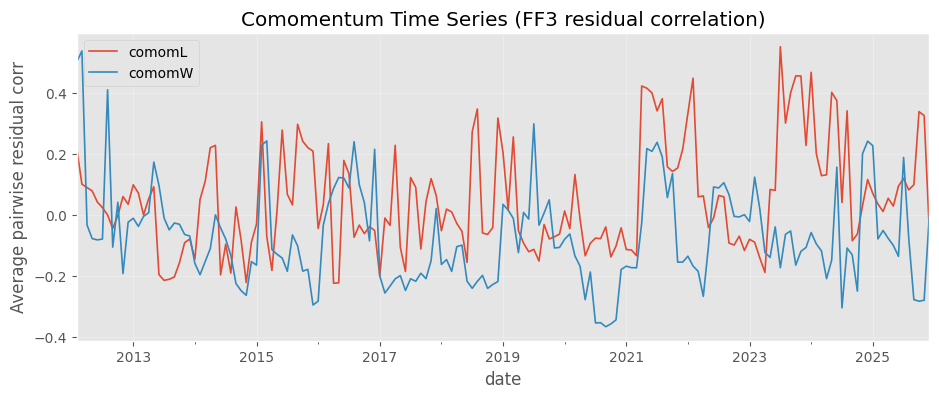

In [6]:
fig, ax = plt.subplots(figsize=(11, 4))
comom_df[['comomL', 'comomW']].plot(ax=ax, lw=1.2)
ax.set_title('Comomentum Time Series (FF3 residual correlation)')
ax.set_ylabel('Average pairwise residual corr')
ax.grid(True, alpha=0.3)
plt.show()


## Strategy Evaluation (`t` decision -> `t+1` apply)


In [7]:
# Build monthly weights from signal
weights = []
for d in mom_signal.index:
    w = build_ls_weights(mom_signal.loc[d], n_long=N_LONG, n_short=N_SHORT)
    w.name = d
    weights.append(w)
weights_df = pd.DataFrame(weights)
weights_df.index = mom_signal.index
weights_df = weights_df.loc[:ANALYSIS_END]

mom_ls_gross = backtest_t_to_t1(weights_df, monthly_ret)
mom_turnover = turnover(weights_df).reindex(mom_ls_gross.index).fillna(0.0)
mom_ls_net = mom_ls_gross - mom_turnover * (COST_BPS / 10000.0)
mom_ls_net.name = 'mom_ls_net'

ret_tbl = pd.concat([mom_ls_gross, mom_ls_net, mom_turnover], axis=1)
display(ret_tbl.head(5))
display(ret_tbl.tail(5))

ann_gross = (1 + mom_ls_gross.dropna()).prod() ** (12 / len(mom_ls_gross.dropna())) - 1
ann_net = (1 + mom_ls_net.dropna()).prod() ** (12 / len(mom_ls_net.dropna())) - 1
vol_gross = mom_ls_gross.dropna().std() * np.sqrt(12)
vol_net = mom_ls_net.dropna().std() * np.sqrt(12)

summary_basic = pd.DataFrame({
    'metric': ['ann_return', 'ann_vol', 'sharpe'],
    'gross': [ann_gross, vol_gross, ann_gross / vol_gross if vol_gross > 0 else np.nan],
    'net': [ann_net, vol_net, ann_net / vol_net if vol_net > 0 else np.nan],
})
display(summary_basic)


mom_ls_gross  mom_ls_net  turnover
Date                                          
2011-02-28           0.0         0.0       0.0
2011-03-31           0.0         0.0       0.0
2011-04-30           0.0         0.0       0.0
2011-05-31           0.0         0.0       0.0
2011-06-30           0.0         0.0       0.0

mom_ls_gross  mom_ls_net  turnover
Date                                          
2025-08-31      0.021959    0.021293  0.666667
2025-09-30      0.031493    0.030826  0.666667
2025-10-31     -0.073721   -0.075055  1.333333
2025-11-30      0.019222    0.019222  0.000000
2025-12-31      0.000000   -0.002000  2.000000

metric     gross       net
0  ann_return -0.008386 -0.017463
1     ann_vol  0.118517  0.118671
2      sharpe -0.070760 -0.147158

In [8]:
def assign_quintile(x: pd.Series, q: int = 5) -> pd.Series:
    s = x.dropna().copy()
    if len(s) < q:
        return pd.Series(index=x.index, dtype='float')
    rank = s.rank(method='first')
    bins = pd.qcut(rank, q=q, labels=False) + 1
    out = pd.Series(index=x.index, dtype='float')
    out.loc[s.index] = bins.astype(float)
    return out


def _forward_mean_return(r: pd.Series, horizon_start: int, horizon_end: int) -> pd.Series:
    vals = []
    idx = []
    n = len(r)
    for i, d in enumerate(r.index):
        a = i + horizon_start - 1
        b = i + horizon_end
        if b > n:
            continue
        vals.append(float(r.iloc[a:b].mean()))
        idx.append(d)
    return pd.Series(vals, index=idx)


def compute_horizon_summary(state_df: pd.DataFrame, horizon_defs: dict[str, tuple[int, int]], lags: int = 12) -> pd.DataFrame:
    rows = []
    for hname, (hs, he) in horizon_defs.items():
        fwd = _forward_mean_return(state_df['r'], hs, he)
        tmp = state_df[['q']].join(fwd.rename('fwd'), how='inner').dropna()

        means = tmp.groupby('q')['fwd'].mean()

        q51 = tmp[tmp['q'].isin([1, 5])].copy()
        q51['is_q5'] = (q51['q'] == 5).astype(float)
        diff_coef, diff_t = _nw_coef_t(q51['fwd'], q51['is_q5'], lags=lags)

        slope, slope_t = _nw_coef_t(tmp['fwd'], tmp['q'].astype(float), lags=lags)

        row = {
            'horizon': hname,
            'n_formations': len(tmp),
            'diff_5_1': diff_coef,
            'diff_5_1_t': diff_t,
            'ols_slope': slope,
            'ols_slope_t': slope_t,
        }
        for k in [1, 2, 3, 4, 5]:
            row[f'q{k}_mean'] = means.get(k, np.nan)
        rows.append(row)

    return pd.DataFrame(rows)


q = assign_quintile(comom_df['comomL'], q=5)
state = pd.DataFrame({'q': q}).dropna()
state['q'] = state['q'].astype(int)

# Align to available strategy returns
state = state.join(mom_ls_gross.rename('r'), how='inner').dropna()

horizon_defs_month = {f'M{m}': (1, m) for m in range(1, 37)}

horizon_defs_year = {
    'Year1': (1, 12),
    'Year2': (13, 24),
    'Year3': (25, 36),
}

quintile_summary_month = compute_horizon_summary(state, horizon_defs_month, lags=12)
quintile_summary_year = compute_horizon_summary(state, horizon_defs_year, lags=12)

# structural checks
expected_month = [f'M{i}' for i in range(1, 37)]
actual_month = quintile_summary_month['horizon'].tolist()
assert quintile_summary_month.shape[0] == 36, 'Month summary row count must be 36.'
assert quintile_summary_year.shape[0] == 3, 'Year summary row count must be 3.'
assert actual_month == expected_month, 'Month horizons are not contiguous M1..M36.'

display(Markdown('### Forward Horizon Summary: Month (Mean Monthly Return, M1..M36)'))
display(quintile_summary_month)

display(Markdown('### Forward Horizon Summary: Year (Mean Monthly Return)'))
display(quintile_summary_year)



### Forward Horizon Summary: Month (Mean Monthly Return, M1..M36)

horizon  n_formations  diff_5_1  diff_5_1_t  ols_slope  ols_slope_t   q1_mean   q2_mean   q3_mean   q4_mean   q5_mean
0       M1           167  0.004421    0.548501   0.000261     0.134829 -0.001061  0.003316 -0.003208 -0.003118  0.003360
1       M2           166  0.000879    0.136745   0.000673     0.491289  0.001596 -0.005455  0.000669 -0.000227  0.002476
2       M3           165  0.002973    0.448298   0.000963     0.695596  0.000151 -0.004236  0.000110 -0.000323  0.003124
3       M4           164  0.004981    0.823872   0.001479     1.179466 -0.002491 -0.004170  0.002241  0.000757  0.002489
4       M5           163  0.005142    0.909866   0.001601     1.388345 -0.002607 -0.004308  0.001560  0.001526  0.002535
5       M6           162  0.004053    0.843238   0.001525     1.535158 -0.002695 -0.004959  0.002524  0.002296  0.001358
6       M7           161  0.002760    0.606538   0.001071     1.089212 -0.001868 -0.003413  0.001198  0.001907  0.000892
7       M8           160  0.003070    0.677245   0.001032     0.969537 -0.001702 -0.003038  0.000897  0.001257  0.001368
8       M9           159  0.004441    0.959640   0.001094     1.010979 -0.002570 -0.001351  0.000378  0.000657  0.001871
9      M10           158  0.005363    1.276907   0.001134     1.140609 -0.002700 -0.000895  0.000182 -0.000439  0.002663
10     M11           157  0.004482    1.211580   0.000864     0.960535 -0.001885 -0.000843 -0.000071 -0.001331  0.002597
11     M12           156  0.004845    1.511559   0.001056     1.304688 -0.001991 -0.001363 -0.000510 -0.000572  0.002854
12     M13           155  0.004706    1.676424   0.001080     1.423032 -0.002004 -0.001623 -0.000377 -0.000318  0.002702
13     M14           154  0.003623    1.334864   0.000822     1.156442 -0.001182 -0.001314 -0.001439 -0.000381  0.002441
14     M15           153  0.003341    1.301910   0.000720     1.131851 -0.000960 -0.001288 -0.001398 -0.000859  0.002380
15     M16           152  0.003659    1.456947   0.000763     1.259529 -0.001028 -0.001337 -0.001366 -0.001158  0.002632
16     M17           151  0.003760    1.800510   0.000766     1.460465 -0.001368 -0.001249 -0.000824 -0.001290  0.002392
17     M18           150  0.003488    1.837988   0.000700     1.533318 -0.001319 -0.001043 -0.001054 -0.001110  0.002170
18     M19           149  0.003537    2.088437   0.000721     1.846247 -0.001122 -0.001217 -0.001437 -0.001120  0.002415
19     M20           148  0.003642    2.296817   0.000674     1.890357 -0.001197 -0.000759 -0.001661 -0.001306  0.002445
20     M21           147  0.003153    2.093771   0.000489     1.438727 -0.000999 -0.000337 -0.001679 -0.001703  0.002154
21     M22           146  0.002892    1.946625   0.000453     1.338090 -0.001044 -0.000316 -0.001630 -0.001592  0.001848
22     M23           145  0.002285    1.575529   0.000347     0.974481 -0.000726 -0.000579 -0.001458 -0.001720  0.001558
23     M24           144  0.002101    1.531660   0.000312     0.892975 -0.000687 -0.000541 -0.001438 -0.001721  0.001414
24     M25           143  0.001994    1.649362   0.000300     0.943362 -0.000564 -0.000690 -0.001533 -0.001627  0.001430
25     M26           142  0.001691    1.551632   0.000270     0.921230 -0.000487 -0.000617 -0.001912 -0.001068  0.001204
26     M27           141  0.001461    1.491474   0.000233     0.839050 -0.000630 -0.000533 -0.001524 -0.000914  0.000831
27     M28           140  0.001254    1.475544   0.000187     0.718823 -0.000495 -0.000720 -0.001253 -0.001084  0.000759
28     M29           139  0.001386    1.518383   0.000213     0.846411 -0.000549 -0.000841 -0.000994 -0.001171  0.000837
29     M30           138  0.001344    1.432918   0.000164     0.651806 -0.000491 -0.000716 -0.000961 -0.001378  0.000853
30     M31           137  0.000977    1.107679   0.000128     0.566954 -0.000579 -0.000638 -0.000830 -0.001022  0.000398
31     M32           136  0.001049    1.246212   0.000161     0.756605 -0.000759 -0.000579 -0.000642 -0.000923  0.000290
32     M33

### Forward Horizon Summary: Year (Mean Monthly Return)

horizon  n_formations  diff_5_1  diff_5_1_t  ols_slope  ols_slope_t   q1_mean   q2_mean   q3_mean   q4_mean   q5_mean
0   Year1           156  0.004845    1.511559   0.001056     1.304688 -0.001991 -0.001363 -0.000510 -0.000572  0.002854
1   Year2           144 -0.000601   -0.202793  -0.000487    -0.587233  0.000617  0.000766 -0.002156 -0.003099  0.000017
2   Year3           132 -0.004713   -2.116094  -0.000894    -1.251226  0.000226  0.000760  0.001242  0.000285 -0.004487

### Month Horizons: Quintile Mean Monthly Return (M1..M36)

horizon   q1_mean   q2_mean   q3_mean   q4_mean   q5_mean  month
0       M1 -0.001061  0.003316 -0.003208 -0.003118  0.003360      1
1       M2  0.001596 -0.005455  0.000669 -0.000227  0.002476      2
2       M3  0.000151 -0.004236  0.000110 -0.000323  0.003124      3
3       M4 -0.002491 -0.004170  0.002241  0.000757  0.002489      4
4       M5 -0.002607 -0.004308  0.001560  0.001526  0.002535      5
5       M6 -0.002695 -0.004959  0.002524  0.002296  0.001358      6
6       M7 -0.001868 -0.003413  0.001198  0.001907  0.000892      7
7       M8 -0.001702 -0.003038  0.000897  0.001257  0.001368      8
8       M9 -0.002570 -0.001351  0.000378  0.000657  0.001871      9
9      M10 -0.002700 -0.000895  0.000182 -0.000439  0.002663     10
10     M11 -0.001885 -0.000843 -0.000071 -0.001331  0.002597     11
11     M12 -0.001991 -0.001363 -0.000510 -0.000572  0.002854     12

horizon   q1_mean   q2_mean   q3_mean   q4_mean   q5_mean  month
24     M25 -0.000564 -0.000690 -0.001533 -0.001627  0.001430     25
25     M26 -0.000487 -0.000617 -0.001912 -0.001068  0.001204     26
26     M27 -0.000630 -0.000533 -0.001524 -0.000914  0.000831     27
27     M28 -0.000495 -0.000720 -0.001253 -0.001084  0.000759     28
28     M29 -0.000549 -0.000841 -0.000994 -0.001171  0.000837     29
29     M30 -0.000491 -0.000716 -0.000961 -0.001378  0.000853     30
30     M31 -0.000579 -0.000638 -0.000830 -0.001022  0.000398     31
31     M32 -0.000759 -0.000579 -0.000642 -0.000923  0.000290     32
32     M33 -0.000564 -0.000748 -0.000492 -0.000960  0.000165     33
33     M34 -0.000292 -0.000525 -0.000746 -0.001115  0.000154     34
34     M35 -0.000311 -0.000389 -0.000291 -0.001448 -0.000007     35
35     M36 -0.000169 -0.000012 -0.000545 -0.001224 -0.000472     36

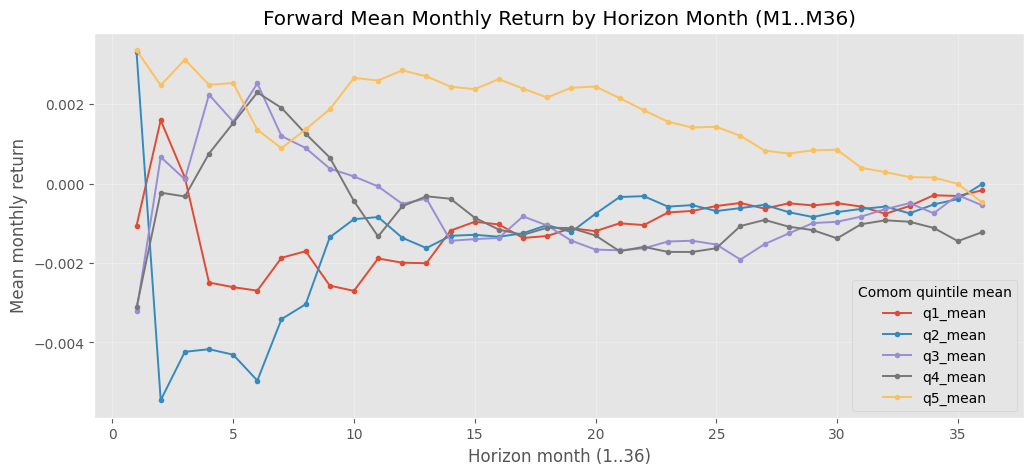

### Year Horizons: Quintile Mean Matrix

Year1     Year2     Year3
q                              
1 -0.001991  0.000617  0.000226
2 -0.001363  0.000766  0.000760
3 -0.000510 -0.002156  0.001242
4 -0.000572 -0.003099  0.000285
5  0.002854  0.000017 -0.004487

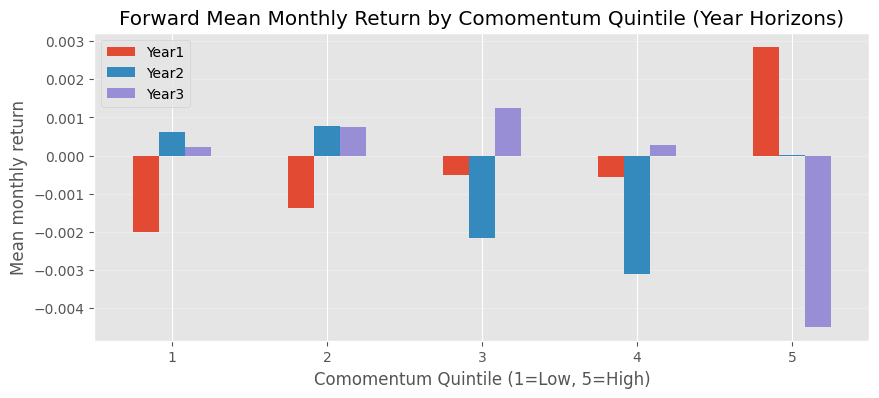

Check M12 vs Year1 (diff_5_1): M12=0.484545%, Year1=0.484545%, abs_diff=0.000000e+00


In [9]:
def _quintile_mean_matrix(state_df: pd.DataFrame, horizon_defs: dict[str, tuple[int, int]]) -> pd.DataFrame:
    mats = []
    for hname, (hs, he) in horizon_defs.items():
        fwd = _forward_mean_return(state_df['r'], hs, he)
        tmp = state_df[['q']].join(fwd.rename('fwd'), how='inner').dropna()
        g = tmp.groupby('q')['fwd'].mean().rename(hname)
        mats.append(g)
    return pd.concat(mats, axis=1)


# Month horizons: line chart for readability (M1..M36)
month_plot = quintile_summary_month[['horizon', 'q1_mean', 'q2_mean', 'q3_mean', 'q4_mean', 'q5_mean']].copy()
month_plot['month'] = month_plot['horizon'].str.replace('M', '', regex=False).astype(int)
month_plot = month_plot.sort_values('month')

display(Markdown('### Month Horizons: Quintile Mean Monthly Return (M1..M36)'))
display(month_plot.head(12))
display(month_plot.tail(12))

fig, ax = plt.subplots(figsize=(12, 5))
for q in ['q1_mean', 'q2_mean', 'q3_mean', 'q4_mean', 'q5_mean']:
    ax.plot(month_plot['month'], month_plot[q], marker='o', markersize=3, linewidth=1.4, label=q)
ax.set_title('Forward Mean Monthly Return by Horizon Month (M1..M36)')
ax.set_xlabel('Horizon month (1..36)')
ax.set_ylabel('Mean monthly return')
ax.grid(True, alpha=0.3)
ax.legend(title='Comom quintile mean')
plt.show()

# Year horizons: keep separate display
bar_df_year = _quintile_mean_matrix(state, horizon_defs_year)
display(Markdown('### Year Horizons: Quintile Mean Matrix'))
display(bar_df_year)

fig, ax = plt.subplots(figsize=(10, 4))
bar_df_year.plot(kind='bar', ax=ax)
ax.set_title('Forward Mean Monthly Return by Comomentum Quintile (Year Horizons)')
ax.set_xlabel('Comomentum Quintile (1=Low, 5=High)')
ax.set_ylabel('Mean monthly return')
ax.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.show()

m12 = quintile_summary_month.loc[quintile_summary_month['horizon'] == 'M12', 'diff_5_1'].iloc[0]
y1 = quintile_summary_year.loc[quintile_summary_year['horizon'] == 'Year1', 'diff_5_1'].iloc[0]
abs_diff = abs(m12 - y1)
print(f'Check M12 vs Year1 (diff_5_1): M12={m12:.6%}, Year1={y1:.6%}, abs_diff={abs_diff:.6e}')
assert abs_diff < 1e-12, 'M12 and Year1 must match within tolerance.'



## Selected-Stock Panel: Congestion vs Future Excess Returns (Fama-MacBeth)


In [10]:
def build_selected_stock_panel(
    mom_signal: pd.DataFrame,
    weekly_excess: pd.DataFrame,
    ff3_weekly: pd.DataFrame,
    lookback_weeks: int,
    n_long: int,
    n_short: int,
) -> pd.DataFrame:
    rows = []
    fac_cols = ['Mkt-RF', 'SMB', 'HML']

    for t in mom_signal.index:
        s = mom_signal.loc[t].dropna()
        if len(s) < (n_long + n_short):
            continue

        selected = {
            'L': list(s.nsmallest(n_short).index),
            'W': list(s.nlargest(n_long).index),
        }

        wk = weekly_excess.loc[weekly_excess.index <= t].tail(lookback_weeks)
        ff = ff3_weekly.loc[ff3_weekly.index <= t].tail(lookback_weeks)
        z = wk.join(ff[fac_cols], how='inner')

        if len(z) < max(26, lookback_weeks // 2):
            continue

        x = z[fac_cols]

        for side, names in selected.items():
            resid = {}
            for ticker in names:
                if ticker not in z.columns:
                    continue
                r = _ols_residual(z[ticker], x)
                if len(r) > 0:
                    resid[ticker] = r

            if len(resid) < 2:
                continue

            resid_df = pd.DataFrame(resid).dropna()
            if resid_df.shape[1] < 2:
                continue

            corr = resid_df.corr()
            for ticker in resid_df.columns:
                peers = [c for c in resid_df.columns if c != ticker]
                if len(peers) == 0:
                    continue

                rows.append({
                    'date': t,
                    'ticker': ticker,
                    'side': side,
                    'congestion': float(corr.loc[ticker, peers].mean()),
                    'rank_signal': float(s.loc[ticker]),
                })

    out = pd.DataFrame(rows)
    if len(out) == 0:
        return pd.DataFrame(columns=['date', 'ticker', 'side', 'congestion', 'rank_signal'])

    out = out.sort_values(['date', 'side', 'ticker']).reset_index(drop=True)
    return out


panel_selected = build_selected_stock_panel(
    mom_signal=mom_signal,
    weekly_excess=weekly_excess,
    ff3_weekly=ff3_weekly,
    lookback_weeks=COMOM_LOOKBACK_WEEKS,
    n_long=N_LONG,
    n_short=N_SHORT,
)

assert set(panel_selected['side'].dropna().unique()).issubset({'L', 'W'}), 'Unexpected side label detected.'

print('panel_selected rows:', len(panel_selected))
print('panel_selected span:', panel_selected['date'].min().date(), '->', panel_selected['date'].max().date())
print('panel_selected by side:')
display(panel_selected.groupby('side')['ticker'].count().rename('n_rows').to_frame())

display(panel_selected.head(10))
display(panel_selected.tail(10))


panel_selected rows: 1002
panel_selected span: 2012-02-29 -> 2025-12-31
panel_selected by side:


n_rows
side        
L        501
W        501

date ticker side  congestion  rank_signal
0 2012-02-29    XLB    L    0.241125    -0.109913
1 2012-02-29    XLF    L    0.186906    -0.194161
2 2012-02-29    XLI    L    0.225677    -0.048385
3 2012-02-29    XLP    W    0.530226     0.157854
4 2012-02-29    XLU    W    0.544767     0.182069
5 2012-02-29    XLV    W    0.430854     0.117582
6 2012-03-31    XLB    L    0.317124    -0.037672
7 2012-03-31    XLE    L    0.051531    -0.086178
8 2012-03-31    XLF    L   -0.064781    -0.151730
9 2012-03-31    XLP    W    0.557101     0.109199

date ticker side  congestion  rank_signal
992  2025-11-30    XLV    L    0.294321    -0.035502
993  2025-11-30    XLF    W   -0.301217     0.176026
994  2025-11-30    XLK    W   -0.294892     0.276324
995  2025-11-30    XLY    W   -0.240306     0.227551
996  2025-12-31    XLB    L    0.104247    -0.078067
997  2025-12-31    XLE    L   -0.267727    -0.046775
998  2025-12-31    XLP    L    0.014120    -0.058762
999  2025-12-31    XLI    W   -0.016565     0.093427
1000 2025-12-31    XLK    W   -0.042052     0.294613
1001 2025-12-31    XLU    W    0.055067     0.105960

In [11]:
def compute_forward_excess_panel(
    monthly_ret: pd.DataFrame,
    ff_monthly: pd.DataFrame,
    panel: pd.DataFrame,
    horizon_defs: dict[str, tuple[int, int]],
) -> pd.DataFrame:
    z = monthly_ret.join(ff_monthly[['RF']], how='inner').dropna(subset=['RF'])
    excess = z[monthly_ret.columns].sub(z['RF'], axis=0)

    idx = excess.index
    pos = {d: i for i, d in enumerate(idx)}

    rows = []
    for row in panel.itertuples(index=False):
        t = row.date
        ticker = row.ticker

        if ticker not in excess.columns or t not in pos:
            continue

        i = pos[t]
        for hname, (a, b) in horizon_defs.items():
            start = i + a
            end = i + b
            if end >= len(idx):
                continue

            seg = excess[ticker].iloc[start:end + 1]
            if seg.isna().any():
                continue

            rows.append({
                'date': t,
                'ticker': ticker,
                'side': row.side,
                'congestion': float(row.congestion),
                'horizon': hname,
                'fwd_excess_mean': float(seg.mean()),
            })

    out = pd.DataFrame(rows)
    if len(out) == 0:
        return pd.DataFrame(columns=['date', 'ticker', 'side', 'congestion', 'horizon', 'fwd_excess_mean'])
    return out


def run_fama_macbeth_horizon(panel_h: pd.DataFrame, lags: int = 12, min_n: int = 3) -> pd.Series:
    beta_rows = []

    for d, g in panel_h.groupby('date'):
        cs = g[['fwd_excess_mean', 'congestion']].dropna()
        if len(cs) < min_n:
            continue
        if cs['congestion'].nunique() < 2:
            continue

        x = sm.add_constant(cs['congestion'])
        fit = sm.OLS(cs['fwd_excess_mean'], x).fit()
        beta_rows.append((d, float(fit.params['congestion'])))

    if len(beta_rows) == 0:
        return pd.Series({'n_months': 0, 'beta_congestion': np.nan, 'beta_t': np.nan})

    beta_ts = pd.Series(
        [b for _, b in beta_rows],
        index=[d for d, _ in beta_rows],
        name='beta_congestion_ts',
    ).sort_index()

    beta_mean, beta_t = newey_west_mean_tstat(beta_ts, lags=lags)
    return pd.Series({
        'n_months': int(beta_ts.shape[0]),
        'beta_congestion': beta_mean,
        'beta_t': beta_t,
    })


def summarize_fm_by_side(panel_fwd: pd.DataFrame, horizon_defs: dict[str, tuple[int, int]], lags: int = 12) -> pd.DataFrame:
    rows = []
    for side in ['L', 'W']:
        for hname in horizon_defs.keys():
            sub = panel_fwd[(panel_fwd['side'] == side) & (panel_fwd['horizon'] == hname)]
            stat = run_fama_macbeth_horizon(sub, lags=lags, min_n=3)
            rows.append({
                'side': side,
                'horizon': hname,
                'n_months': int(stat['n_months']),
                'beta_congestion': stat['beta_congestion'],
                'beta_t': stat['beta_t'],
            })
    return pd.DataFrame(rows)


panel_fwd_month = compute_forward_excess_panel(
    monthly_ret=monthly_ret,
    ff_monthly=ff_monthly,
    panel=panel_selected,
    horizon_defs=horizon_defs_month,
)
panel_fwd_year = compute_forward_excess_panel(
    monthly_ret=monthly_ret,
    ff_monthly=ff_monthly,
    panel=panel_selected,
    horizon_defs=horizon_defs_year,
)

fm_summary_month = summarize_fm_by_side(panel_fwd_month, horizon_defs_month, lags=12)
fm_summary_year = summarize_fm_by_side(panel_fwd_year, horizon_defs_year, lags=12)

assert set(panel_selected['side'].dropna().unique()) == {'L', 'W'}, 'Both L and W sides are required.'
assert fm_summary_month.shape[0] == 36 * 2, 'fm_summary_month must have 72 rows.'
assert fm_summary_year.shape[0] == 3 * 2, 'fm_summary_year must have 6 rows.'
assert (fm_summary_month['n_months'] > 0).all(), 'Each month horizon must have at least one cross-section month.'
assert (fm_summary_year['n_months'] > 0).all(), 'Each year horizon must have at least one cross-section month.'

for side in ['L', 'W']:
    m12 = fm_summary_month.loc[(fm_summary_month['side'] == side) & (fm_summary_month['horizon'] == 'M12'), 'beta_congestion'].iloc[0]
    y1 = fm_summary_year.loc[(fm_summary_year['side'] == side) & (fm_summary_year['horizon'] == 'Year1'), 'beta_congestion'].iloc[0]
    assert abs(m12 - y1) < 1e-12, f'M12 and Year1 mismatch for side={side}'


display(Markdown('### Selected-Stock Panel (head / tail)'))
display(panel_selected.head(10))
display(panel_selected.tail(10))

display(Markdown("### Fama-MacBeth Summary: Month Horizons (Loser side='L')"))
display(fm_summary_month.query("side == 'L'").reset_index(drop=True))

display(Markdown("### Fama-MacBeth Summary: Month Horizons (Winner side='W')"))
display(fm_summary_month.query("side == 'W'").reset_index(drop=True))

display(Markdown('### Fama-MacBeth Summary: Year Horizons (L/W)'))
display(fm_summary_year)


### Selected-Stock Panel (head / tail)

date ticker side  congestion  rank_signal
0 2012-02-29    XLB    L    0.241125    -0.109913
1 2012-02-29    XLF    L    0.186906    -0.194161
2 2012-02-29    XLI    L    0.225677    -0.048385
3 2012-02-29    XLP    W    0.530226     0.157854
4 2012-02-29    XLU    W    0.544767     0.182069
5 2012-02-29    XLV    W    0.430854     0.117582
6 2012-03-31    XLB    L    0.317124    -0.037672
7 2012-03-31    XLE    L    0.051531    -0.086178
8 2012-03-31    XLF    L   -0.064781    -0.151730
9 2012-03-31    XLP    W    0.557101     0.109199

date ticker side  congestion  rank_signal
992  2025-11-30    XLV    L    0.294321    -0.035502
993  2025-11-30    XLF    W   -0.301217     0.176026
994  2025-11-30    XLK    W   -0.294892     0.276324
995  2025-11-30    XLY    W   -0.240306     0.227551
996  2025-12-31    XLB    L    0.104247    -0.078067
997  2025-12-31    XLE    L   -0.267727    -0.046775
998  2025-12-31    XLP    L    0.014120    -0.058762
999  2025-12-31    XLI    W   -0.016565     0.093427
1000 2025-12-31    XLK    W   -0.042052     0.294613
1001 2025-12-31    XLU    W    0.055067     0.105960

### Fama-MacBeth Summary: Month Horizons (Loser side='L')

side horizon  n_months  beta_congestion    beta_t
0     L      M1       166        -0.055900 -1.802762
1     L      M2       165        -0.027015 -1.375435
2     L      M3       164        -0.016377 -1.568477
3     L      M4       163        -0.021043 -1.987312
4     L      M5       162        -0.024513 -1.937178
5     L      M6       161        -0.023035 -1.414444
6     L      M7       160        -0.013722 -1.129566
7     L      M8       159        -0.011282 -0.833247
8     L      M9       158        -0.007290 -0.594816
9     L     M10       157        -0.004649 -0.402933
10    L     M11       156        -0.004866 -0.406097
11    L     M12       155        -0.006531 -0.543326
12    L     M13       154        -0.005115 -0.486332
13    L     M14       153        -0.004810 -0.481304
14    L     M15       152        -0.007912 -0.739175
15    L     M16       151        -0.006488 -0.605995
16    L     M17       150        -0.003897 -0.404864
17    L     M18       149        -0.006379 -0.657012
18    L     M19       148        -0.004886 -0.505165
19    L     M20       147        -0.001235 -0.131767
20    L     M21       146        -0.001402 -0.148847
21    L     M22       145        -0.003847 -0.406664
22    L     M23       144        -0.005797 -0.624979
23    L     M24       143        -0.004746 -0.557804
24    L     M25       142        -0.004247 -0.509205
25    L     M26       141        -0.005201 -0.656194
26    L     M27       140        -0.003368 -0.439417
27    L     M28       139        -0.001006 -0.128413
28    L     M29       138        -0.000107 -0.013515
29    L     M30       137         0.000078  0.010410
30    L     M31       136        -0.000793 -0.102256
31    L     M32       135        -0.001805 -0.236139
32    L     M33       134        -0.002968 -0.407521
33    L     M34       133        -0.003277 -0.472024
34    L     M35       132        -0.001673 -0.254333
35    L     M36       131        -0.003172 -0.516252

### Fama-MacBeth Summary: Month Horizons (Winner side='W')

side horizon  n_months  beta_congestion    beta_t
0     W      M1       166        -0.043351 -2.207747
1     W      M2       165        -0.039146 -2.344305
2     W      M3       164        -0.027068 -1.794780
3     W      M4       163        -0.019937 -1.408594
4     W      M5       162        -0.014338 -1.159349
5     W      M6       161        -0.016552 -1.464544
6     W      M7       160        -0.016422 -1.562665
7     W      M8       159        -0.017181 -1.831401
8     W      M9       158        -0.017278 -1.970608
9     W     M10       157        -0.019599 -2.217779
10    W     M11       156        -0.017706 -1.979398
11    W     M12       155        -0.017338 -1.913985
12    W     M13       154        -0.017361 -2.111022
13    W     M14       153        -0.019041 -2.473172
14    W     M15       152        -0.022176 -2.827731
15    W     M16       151        -0.024672 -3.056248
16    W     M17       150        -0.024063 -3.169469
17    W     M18       149        -0.025653 -3.183914
18    W     M19       148        -0.028352 -3.579125
19    W     M20       147        -0.027857 -3.638828
20    W     M21       146        -0.026530 -3.724074
21    W     M22       145        -0.026181 -3.383920
22    W     M23       144        -0.026350 -3.220362
23    W     M24       143        -0.027709 -3.260736
24    W     M25       142        -0.028022 -3.329754
25    W     M26       141        -0.026366 -3.241556
26    W     M27       140        -0.023501 -3.136454
27    W     M28       139        -0.023219 -3.404604
28    W     M29       138        -0.022662 -3.540928
29    W     M30       137        -0.021228 -3.582617
30    W     M31       136        -0.020815 -3.606230
31    W     M32       135        -0.020306 -3.276005
32    W     M33       134        -0.019767 -3.234301
33    W     M34       133        -0.019454 -3.409501
34    W     M35       132        -0.020134 -3.741623
35    W     M36       131        -0.019534 -4.003187

### Fama-MacBeth Summary: Year Horizons (L/W)

side horizon  n_months  beta_congestion    beta_t
0    L   Year1       155        -0.006531 -0.543326
1    L   Year2       143        -0.000854 -0.054433
2    L   Year3       131         0.000593  0.051541
3    W   Year1       155        -0.017338 -1.913985
4    W   Year2       143        -0.035347 -2.494959
5    W   Year3       131        -0.006578 -0.810257

### FM Beta by Month Horizon (Congestion -> Future Excess Return)

side          L         W
month                    
1     -0.055900 -0.043351
2     -0.027015 -0.039146
3     -0.016377 -0.027068
4     -0.021043 -0.019937
5     -0.024513 -0.014338
6     -0.023035 -0.016552
7     -0.013722 -0.016422
8     -0.011282 -0.017181
9     -0.007290 -0.017278
10    -0.004649 -0.019599
11    -0.004866 -0.017706
12    -0.006531 -0.017338

side          L         W
month                    
25    -0.004247 -0.028022
26    -0.005201 -0.026366
27    -0.003368 -0.023501
28    -0.001006 -0.023219
29    -0.000107 -0.022662
30     0.000078 -0.021228
31    -0.000793 -0.020815
32    -0.001805 -0.020306
33    -0.002968 -0.019767
34    -0.003277 -0.019454
35    -0.001673 -0.020134
36    -0.003172 -0.019534

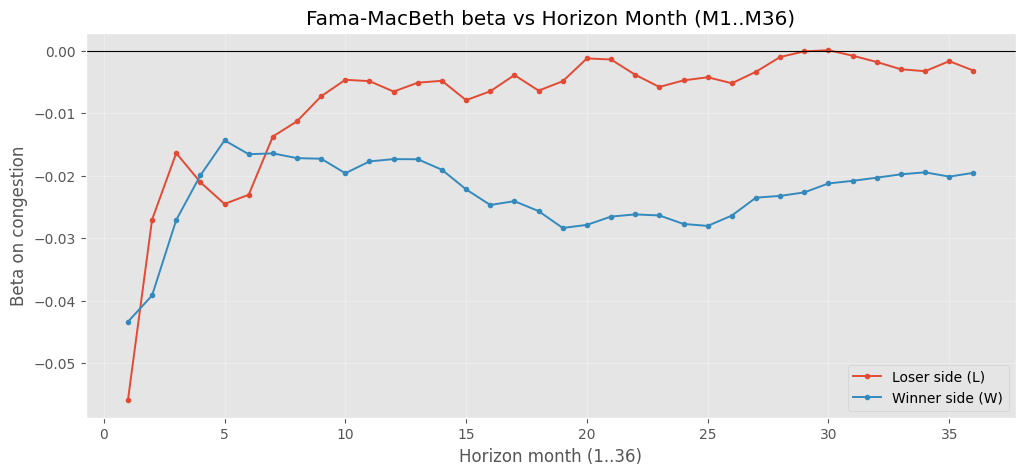

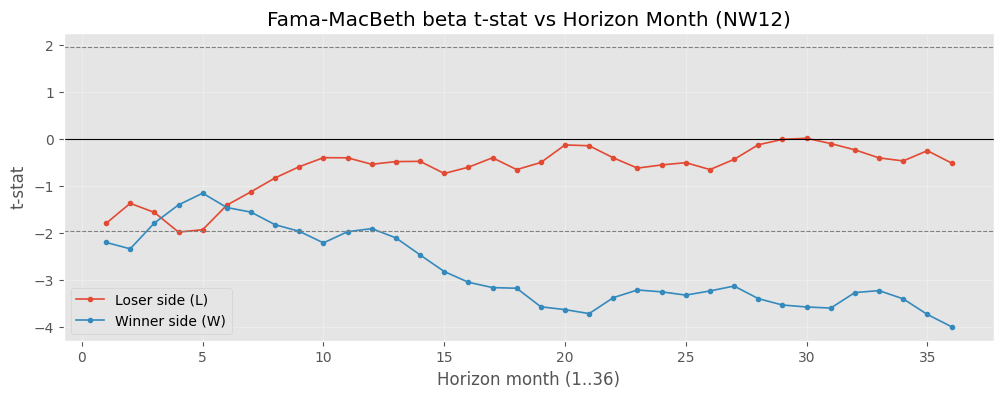

### FM Beta: Year Horizons

side            L         W
horizon                    
Year1   -0.006531 -0.017338
Year2   -0.000854 -0.035347
Year3    0.000593 -0.006578

In [12]:
fm_month_plot = fm_summary_month.copy()
fm_month_plot['month'] = fm_month_plot['horizon'].str.replace('M', '', regex=False).astype(int)
fm_month_plot = fm_month_plot.sort_values(['side', 'month'])

beta_line = fm_month_plot.pivot(index='month', columns='side', values='beta_congestion').sort_index()
t_line = fm_month_plot.pivot(index='month', columns='side', values='beta_t').sort_index()

display(Markdown('### FM Beta by Month Horizon (Congestion -> Future Excess Return)'))
display(beta_line.head(12))
display(beta_line.tail(12))

fig, ax = plt.subplots(figsize=(12, 5))
for side, label in [('L', 'Loser side (L)'), ('W', 'Winner side (W)')]:
    if side in beta_line.columns:
        ax.plot(beta_line.index, beta_line[side], marker='o', markersize=3, linewidth=1.4, label=label)
ax.axhline(0.0, color='black', linewidth=0.8)
ax.set_title('Fama-MacBeth beta vs Horizon Month (M1..M36)')
ax.set_xlabel('Horizon month (1..36)')
ax.set_ylabel('Beta on congestion')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
for side, label in [('L', 'Loser side (L)'), ('W', 'Winner side (W)')]:
    if side in t_line.columns:
        ax.plot(t_line.index, t_line[side], marker='o', markersize=3, linewidth=1.2, label=label)
ax.axhline(0.0, color='black', linewidth=0.8)
ax.axhline(1.96, color='gray', linestyle='--', linewidth=0.8)
ax.axhline(-1.96, color='gray', linestyle='--', linewidth=0.8)
ax.set_title('Fama-MacBeth beta t-stat vs Horizon Month (NW12)')
ax.set_xlabel('Horizon month (1..36)')
ax.set_ylabel('t-stat')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

year_beta = fm_summary_year.pivot(index='horizon', columns='side', values='beta_congestion')
display(Markdown('### FM Beta: Year Horizons'))
display(year_beta)


## Carhart4 Risk Adjustment (Monthly)


/var/folders/8t/t2778mwd6nj4y3___trtrwl00000gn/T/ipykernel_85644/403093769.py:25: Pandas4Warning: Sorting by default when concatenating all DatetimeIndex is deprecated.  In the future, pandas will respect the default of `sort=False`. Specify `sort=True` or `sort=False` to silence this message. If you see this warnings when not directly calling concat, report a bug to pandas.
  z = pd.concat([ret_realized.rename('ret'), factors], axis=1).dropna()
/var/folders/8t/t2778mwd6nj4y3___trtrwl00000gn/T/ipykernel_85644/403093769.py:25: Pandas4Warning: Sorting by default when concatenating all DatetimeIndex is deprecated.  In the future, pandas will respect the default of `sort=False`. Specify `sort=True` or `sort=False` to silence this message. If you see this warnings when not directly calling concat, report a bug to pandas.
  z = pd.concat([ret_realized.rename('ret'), factors], axis=1).dropna()


n   alpha_m   alpha_t  alpha_ann
Low_comom_q1   34.0 -0.004141 -0.844720  -0.049687
High_comom_q5  34.0 -0.004439 -1.669922  -0.053273

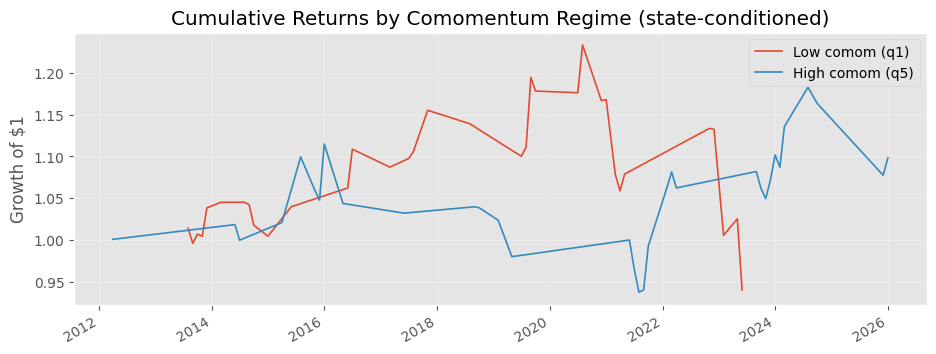

In [13]:
def decision_to_realized_index(decision_series: pd.Series, monthly_index: pd.DatetimeIndex) -> pd.Series:
    pos = {d: i for i, d in enumerate(monthly_index)}
    vals = []
    idx = []
    for d, v in decision_series.dropna().items():
        if d not in pos or pos[d] + 1 >= len(monthly_index):
            continue
        rd = monthly_index[pos[d] + 1]
        idx.append(rd)
        vals.append(v)
    return pd.Series(vals, index=idx)


state_ret = state[['q', 'r']].copy()
low_dec = state_ret.loc[state_ret['q'] == 1, 'r']
high_dec = state_ret.loc[state_ret['q'] == 5, 'r']

low_real = decision_to_realized_index(low_dec, monthly_ret.index)
high_real = decision_to_realized_index(high_dec, monthly_ret.index)

fac = ff_monthly[['Mkt-RF', 'SMB', 'HML', 'Mom', 'RF']].copy()


def carhart_alpha(ret_realized: pd.Series, factors: pd.DataFrame) -> pd.Series:
    z = pd.concat([ret_realized.rename('ret'), factors], axis=1).dropna()
    if len(z) < 24:
        return pd.Series({'n': len(z), 'alpha_m': np.nan, 'alpha_t': np.nan})
    y = z['ret'] - z['RF']
    x = sm.add_constant(z[['Mkt-RF', 'SMB', 'HML', 'Mom']])
    fit = sm.OLS(y, x).fit(cov_type='HAC', cov_kwds={'maxlags': min(12, len(z)-2)})
    return pd.Series({'n': len(z), 'alpha_m': fit.params['const'], 'alpha_t': fit.tvalues['const']})


alpha_low = carhart_alpha(low_real, fac)
alpha_high = carhart_alpha(high_real, fac)
alpha_tbl = pd.DataFrame({'Low_comom_q1': alpha_low, 'High_comom_q5': alpha_high}).T
alpha_tbl['alpha_ann'] = alpha_tbl['alpha_m'] * 12.0

display(alpha_tbl)

low_path = (1 + low_real.fillna(0.0)).cumprod()
high_path = (1 + high_real.fillna(0.0)).cumprod()

fig, ax = plt.subplots(figsize=(11, 4))
low_path.plot(ax=ax, lw=1.2, label='Low comom (q1)')
high_path.plot(ax=ax, lw=1.2, label='High comom (q5)')
ax.set_title('Cumulative Returns by Comomentum Regime (state-conditioned)')
ax.set_ylabel('Growth of $1')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()


## PIT Check (`signal_date < apply_date`)


In [14]:
pit_df = run_pit_checks(weights_df, monthly_ret)
assert len(pit_df) > 0, 'PIT check rows are empty.'
assert pit_df['signal_lt_apply'].all(), 'PIT violation detected: signal_date >= apply_date.'

print('PIT CHECK: PASS')
print('rows:', len(pit_df))
display(pit_df.head(5))
display(pit_df.tail(5))


PIT CHECK: PASS
rows: 178


signal_date apply_date  signal_lt_apply check
0  2011-02-28 2011-03-31             True  PASS
1  2011-03-31 2011-04-30             True  PASS
2  2011-04-30 2011-05-31             True  PASS
3  2011-05-31 2011-06-30             True  PASS
4  2011-06-30 2011-07-31             True  PASS

signal_date apply_date  signal_lt_apply check
173  2025-07-31 2025-08-31             True  PASS
174  2025-08-31 2025-09-30             True  PASS
175  2025-09-30 2025-10-31             True  PASS
176  2025-10-31 2025-11-30             True  PASS
177  2025-11-30 2025-12-31             True  PASS

## Final Summary (Notebook表示)


In [15]:
comom_stats = comom_df[['comomL', 'comomW']].describe().loc[['mean', 'std', 'min', 'max']]

k_m1 = quintile_summary_month.loc[quintile_summary_month['horizon'] == 'M1', 'diff_5_1'].iloc[0]
k_m3 = quintile_summary_month.loc[quintile_summary_month['horizon'] == 'M3', 'diff_5_1'].iloc[0]
k_m6 = quintile_summary_month.loc[quintile_summary_month['horizon'] == 'M6', 'diff_5_1'].iloc[0]
k_m12 = quintile_summary_month.loc[quintile_summary_month['horizon'] == 'M12', 'diff_5_1'].iloc[0]
k_m24 = quintile_summary_month.loc[quintile_summary_month['horizon'] == 'M24', 'diff_5_1'].iloc[0]
k_m36 = quintile_summary_month.loc[quintile_summary_month['horizon'] == 'M36', 'diff_5_1'].iloc[0]

k_y1 = quintile_summary_year.loc[quintile_summary_year['horizon'] == 'Year1', 'diff_5_1'].iloc[0]
k_y2 = quintile_summary_year.loc[quintile_summary_year['horizon'] == 'Year2', 'diff_5_1'].iloc[0]
k_y3 = quintile_summary_year.loc[quintile_summary_year['horizon'] == 'Year3', 'diff_5_1'].iloc[0]


def _pick_fm(tbl: pd.DataFrame, side: str, horizon: str, col: str = 'beta_congestion') -> float:
    s = tbl.loc[(tbl['side'] == side) & (tbl['horizon'] == horizon), col]
    if len(s) == 0:
        return np.nan
    return float(s.iloc[0])


fm_l_m1 = _pick_fm(fm_summary_month, 'L', 'M1')
fm_l_m3 = _pick_fm(fm_summary_month, 'L', 'M3')
fm_l_m6 = _pick_fm(fm_summary_month, 'L', 'M6')
fm_l_m12 = _pick_fm(fm_summary_month, 'L', 'M12')
fm_l_m24 = _pick_fm(fm_summary_month, 'L', 'M24')
fm_l_m36 = _pick_fm(fm_summary_month, 'L', 'M36')

fm_w_m1 = _pick_fm(fm_summary_month, 'W', 'M1')
fm_w_m3 = _pick_fm(fm_summary_month, 'W', 'M3')
fm_w_m6 = _pick_fm(fm_summary_month, 'W', 'M6')
fm_w_m12 = _pick_fm(fm_summary_month, 'W', 'M12')
fm_w_m24 = _pick_fm(fm_summary_month, 'W', 'M24')
fm_w_m36 = _pick_fm(fm_summary_month, 'W', 'M36')

fm_l_y1 = _pick_fm(fm_summary_year, 'L', 'Year1')
fm_l_y2 = _pick_fm(fm_summary_year, 'L', 'Year2')
fm_l_y3 = _pick_fm(fm_summary_year, 'L', 'Year3')

fm_w_y1 = _pick_fm(fm_summary_year, 'W', 'Year1')
fm_w_y2 = _pick_fm(fm_summary_year, 'W', 'Year2')
fm_w_y3 = _pick_fm(fm_summary_year, 'W', 'Year3')

msg = f"""
### Phase B 結果要約（9ETFプロキシ）

- 分析期間: **{comom_df.index.min().date()} ～ {comom_df.index.max().date()}**
- comomentum 有効観測数: **{len(comom_df)}**
- `comomL` 平均: **{comom_stats.loc['mean', 'comomL']:.4f}**
- `comomW` 平均: **{comom_stats.loc['mean', 'comomW']:.4f}**

Month horizons `5-1`（高comom-低comom, 平均月次）:
- M1: **{k_m1:.4%}**
- M3: **{k_m3:.4%}**
- M6: **{k_m6:.4%}**
- M12: **{k_m12:.4%}**
- M24: **{k_m24:.4%}**
- M36: **{k_m36:.4%}**

Year horizons `5-1`（高comom-低comom, 平均月次）:
- Year1: **{k_y1:.4%}**
- Year2: **{k_y2:.4%}**
- Year3: **{k_y3:.4%}**

採択銘柄パネルFM（混雑度 -> 将来超過収益, beta）:
- Loser side (L) M1/M3/M6/M12/M24/M36:
  **{fm_l_m1:.4%}, {fm_l_m3:.4%}, {fm_l_m6:.4%}, {fm_l_m12:.4%}, {fm_l_m24:.4%}, {fm_l_m36:.4%}**
- Winner side (W) M1/M3/M6/M12/M24/M36:
  **{fm_w_m1:.4%}, {fm_w_m3:.4%}, {fm_w_m6:.4%}, {fm_w_m12:.4%}, {fm_w_m24:.4%}, {fm_w_m36:.4%}**
- Year horizons (L / W):
  - Year1: **{fm_l_y1:.4%} / {fm_w_y1:.4%}**
  - Year2: **{fm_l_y2:.4%} / {fm_w_y2:.4%}**
  - Year3: **{fm_l_y3:.4%} / {fm_w_y3:.4%}**

注記:
- `M12` と `Year1` は同一窓（1-12か月）なので、定義上重複する。
- 各月で採択銘柄は再決定されるため、同一銘柄の所属は月次で変化し得る。
- 推定単位は形成月ごとの反復横断面であり、固定バスケット追跡ではない。
- `M24` は `Year1-2`（13-24か月）ではなく、`1-24` の平均月次である。
- PITチェック: **PASS**

未実装（データ不足のため）:
- 13F機関保有・ヘッジファンドAUM・shadow banking連動回帰
- 国際株式19市場と通貨モメンタム拡張
- 論文の個別株CRSP完全再現
"""

display(Markdown(msg))

print('No file outputs were written by this notebook (display-only mode).')



### Phase B 結果要約（9ETFプロキシ）

- 分析期間: **2012-02-29 ～ 2025-12-31**
- comomentum 有効観測数: **167**
- `comomL` 平均: **0.0510**
- `comomW` 平均: **-0.0692**

Month horizons `5-1`（高comom-低comom, 平均月次）:
- M1: **0.4421%**
- M3: **0.2973%**
- M6: **0.4053%**
- M12: **0.4845%**
- M24: **0.2101%**
- M36: **-0.0303%**

Year horizons `5-1`（高comom-低comom, 平均月次）:
- Year1: **0.4845%**
- Year2: **-0.0601%**
- Year3: **-0.4713%**

採択銘柄パネルFM（混雑度 -> 将来超過収益, beta）:
- Loser side (L) M1/M3/M6/M12/M24/M36:
  **-5.5900%, -1.6377%, -2.3035%, -0.6531%, -0.4746%, -0.3172%**
- Winner side (W) M1/M3/M6/M12/M24/M36:
  **-4.3351%, -2.7068%, -1.6552%, -1.7338%, -2.7709%, -1.9534%**
- Year horizons (L / W):
  - Year1: **-0.6531% / -1.7338%**
  - Year2: **-0.0854% / -3.5347%**
  - Year3: **0.0593% / -0.6578%**

注記:
- `M12` と `Year1` は同一窓（1-12か月）なので、定義上重複する。
- 各月で採択銘柄は再決定されるため、同一銘柄の所属は月次で変化し得る。
- 推定単位は形成月ごとの反復横断面であり、固定バスケット追跡ではない。
- `M24` は `Year1-2`（13-24か月）ではなく、`1-24` の平均月次である。
- PITチェック: **PASS**

未実装（データ不足のため）:
- 13F機関保有・ヘッジファンドAUM・shadow banking連動回帰
- 国際株式19市場と通貨モメンタム拡張
- 論文の個別株CRSP完全再現


No file outputs were written by this notebook (display-only mode).
